In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os


from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters import sobel 
from skimage.feature._canny import canny
from skimage.color import rgb2gray
from skimage.restoration import denoise_bilateral, denoise_tv_chambolle
from skimage.transform import resize
from sklearn.cluster import KMeans

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

%matplotlib inline


In [129]:
!ls

 3_29_2021_dry_run_1.ipynb			    4_1_2021_with_png.ipynb
 3_29_2021_dry_run.ipynb			    class_map_corrected.csv
 3_30_2021_dry_run.ipynb			    kalpurush-2.ttf
 3_31_2021_dry_run-more_layers_n_pools.ipynb	    logs
 3_31_2021_dry_run_with_layer_learning_rate.ipynb   model.png
 3_31_2021_resnet50.ipynb			    sample_submission.csv
'3_31_night_thanks_to_Kaushal Shah.ipynb'	    test.csv
 4_1_2021_dry_run.ipynb				    train.csv


In [130]:
df_index=pd.read_csv('train.csv')
df_index

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো
...,...,...,...,...,...
200835,Train_200835,22,7,2,র্খে
200836,Train_200836,65,9,0,ত্তো
200837,Train_200837,2,1,4,অ্যা
200838,Train_200838,152,9,0,স্নো


In [131]:
df_index.shape

(200840, 5)

<AxesSubplot:>

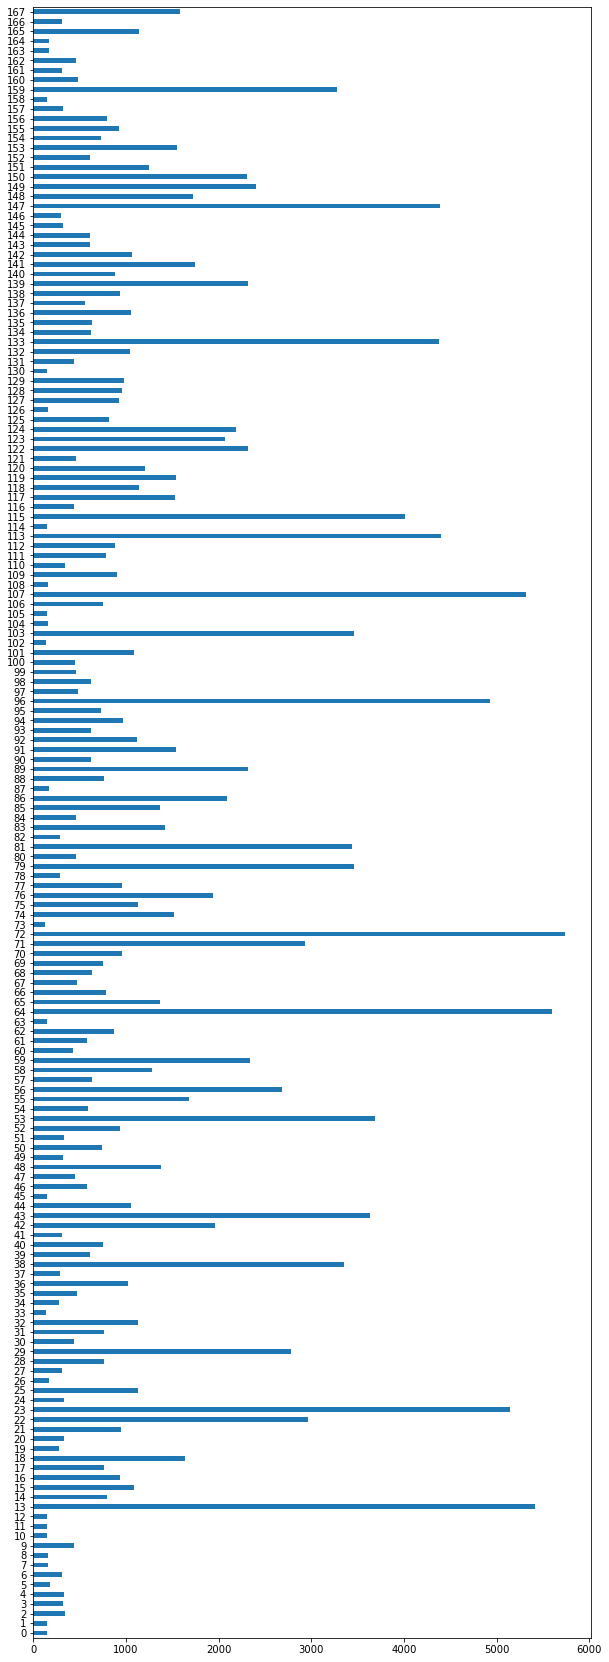

In [132]:
plt.figure(figsize=(10,30))
df_index['grapheme_root'].value_counts().sort_index().plot.barh()  

<AxesSubplot:>

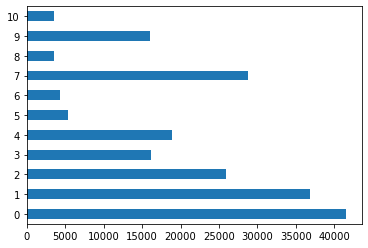

In [133]:
df_index['vowel_diacritic'].value_counts().sort_index().plot.barh()  

<AxesSubplot:>

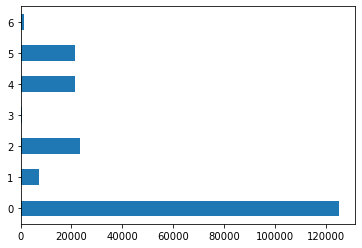

In [134]:
df_index['consonant_diacritic'].value_counts().sort_index().plot.barh()  

In [135]:
df_index['image_id']=df_index['image_id']+'.png'

In [136]:
df_index

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0.png,15,9,5,ক্ট্রো
1,Train_1.png,159,0,0,হ
2,Train_2.png,22,3,5,খ্রী
3,Train_3.png,53,2,2,র্টি
4,Train_4.png,71,9,5,থ্রো
...,...,...,...,...,...
200835,Train_200835.png,22,7,2,র্খে
200836,Train_200836.png,65,9,0,ত্তো
200837,Train_200837.png,2,1,4,অ্যা
200838,Train_200838.png,152,9,0,স্নো


In [137]:
df_index['consonant_diacritic'].value_counts() 
#7 values , # 7 columns one hot coding, output = 7 colums and softmax

0    125278
2     23465
5     21397
4     21270
1      7424
6      1387
3       619
Name: consonant_diacritic, dtype: int64

In [138]:
df_index.dtypes

image_id               object
grapheme_root           int64
vowel_diacritic         int64
consonant_diacritic     int64
grapheme               object
dtype: object

In [139]:
df_shuffle = df_index.sample(frac=1) #shuffle

In [140]:
train = df_shuffle.iloc[:int(0.8*len(df_index)),:]
test = df_shuffle.iloc[int(0.8*len(df_index)):,:]

In [141]:
train.sample().shape

(1, 5)

In [142]:
128*128

16384

In [143]:
df_index.head(1)

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0.png,15,9,5,ক্ট্রো


In [144]:
from PIL import Image 

def mygenerator1(dataframe): # X = image, y = target
    while True:
        sample = dataframe.sample()
        TRAIN_DIR = '/home/beth/Galvanize/capstone/capstone_2_new/capstone_2/train_img/img/'
        image_name = TRAIN_DIR + sample['image_id'].values[0]
        image=Image.open(image_name)
        X = np.array(image).astype(np.int32)
        X = X.reshape(1,128,128,1)
        y1=np.zeros(7)
        y1[sample["consonant_diacritic"].values[0]]=1  
        y1 = y1.astype(np.int32).reshape(1,7) 
#         X = np.array([X,X,X]).reshape(1,137,236,3)
        yield X,y1
# infinite numbers of X and y    

In [145]:
from PIL import Image 

def mygenerator2(dataframe): # X = image, y = target
    while True:
        sample = dataframe.sample()
        TRAIN_DIR = '/home/beth/Galvanize/capstone/capstone_2_new/capstone_2/train_img/img/'
        image_name = TRAIN_DIR + sample['image_id'].values[0]
        image=Image.open(image_name)
        X = np.array(image).astype(np.int32)
        X = X.reshape(1,128,128,1)
        y2=np.zeros(11)
        y2[sample["vowel_diacritic"].values[0]]=1  
        y2 = y2.astype(np.int32).reshape(1,11) 
#         X = np.array([X,X,X]).reshape(1,137,236,3)

        yield X,y2
# infinite numbers of X and y    

In [112]:
from PIL import Image 

def mygenerator3(dataframe): # X = image, y = target
    while True:
        sample = dataframe.sample()
        TRAIN_DIR = '/home/beth/Galvanize/capstone/capstone_2_new/capstone_2/train_img/img/'
        image_name = TRAIN_DIR + sample['image_id'].values[0]
        image=Image.open(image_name)
        X = np.array(image).astype(np.int32)
        X = X.reshape(1,128,128,1)        
        y3=np.zeros(168)
        y3[sample["grapheme_root"].values[0]]=1  
        y3 = y3.astype(np.int32).reshape(1,168) 
#         X = np.array([X,X,X]).reshape(1,137,236,3)
        yield X,y3
# infinite numbers of X and y    

In [113]:
X,y1 = next(mygenerator1(train)) # randomly pick a row 

In [114]:
X.shape

(1, 128, 128, 1)

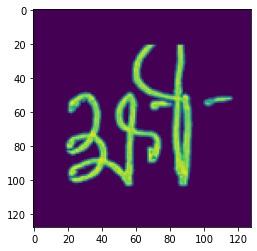

In [115]:
plt.imshow(X[0,:,:,0])

In [116]:
y1.shape

(1, 7)

In [ ]:
# https://www.kaggle.com/iafoss/image-preprocessing-128x128?select=train.zip

# Image preprocessing (128x128)

In [ ]:
# import cv2
# from tqdm import tqdm_notebook as tqdm
# import zipfile
# import io
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import warnings
# warnings.filterwarnings("ignore")

In [ ]:
# HEIGHT = 137
# WIDTH = 236
# SIZE = 128

# TRAIN = ['/kaggle/input/bengaliai-cv19/train_image_data_0.parquet',
#          '/kaggle/input/bengaliai-cv19/train_image_data_1.parquet',
#          '/kaggle/input/bengaliai-cv19/train_image_data_2.parquet',
#          '/kaggle/input/bengaliai-cv19/train_image_data_3.parquet']

# OUT_TRAIN = 'train.zip'

In [ ]:
# def bbox(img):
#     rows = np.any(img, axis=1)
#     cols = np.any(img, axis=0)
#     rmin, rmax = np.where(rows)[0][[0, -1]]
#     cmin, cmax = np.where(cols)[0][[0, -1]]
#     return rmin, rmax, cmin, cmax

# def crop_resize(img0, size=SIZE, pad=16):
#     #crop a box around pixels large than the threshold 
#     #some images contain line at the sides
#     ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > 80)
#     #cropping may cut too much, so we need to add it back
#     xmin = xmin - 13 if (xmin > 13) else 0
#     ymin = ymin - 10 if (ymin > 10) else 0
#     xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
#     ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
#     img = img0[ymin:ymax,xmin:xmax]
#     #remove lo intensity pixels as noise
#     img[img < 28] = 0
#     lx, ly = xmax-xmin,ymax-ymin
#     l = max(lx,ly) + pad
#     #make sure that the aspect ratio is kept in rescaling
#     img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
#     return cv2.resize(img,(size,size))

In [ ]:
# df = pd.read_parquet(TRAIN[0])
# n_imgs = 8
# fig, axs = plt.subplots(n_imgs, 2, figsize=(10, 5*n_imgs))

# for idx in range(n_imgs):
#     #somehow the original input is inverted
#     img0 = 255 - df.iloc[idx, 1:].values.reshape(HEIGHT, WIDTH).astype(np.uint8)
#     #normalize each image by its max val
#     img = (img0*(255.0/img0.max())).astype(np.uint8)
#     img = crop_resize(img)

#     axs[idx,0].imshow(img0)
#     axs[idx,0].set_title('Original image')
#     axs[idx,0].axis('off')
#     axs[idx,1].imshow(img)
#     axs[idx,1].set_title('Crop & resize')
#     axs[idx,1].axis('off')
# plt.show()

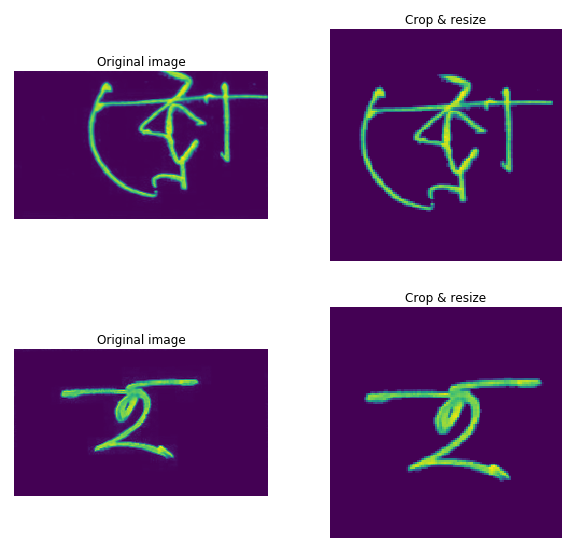

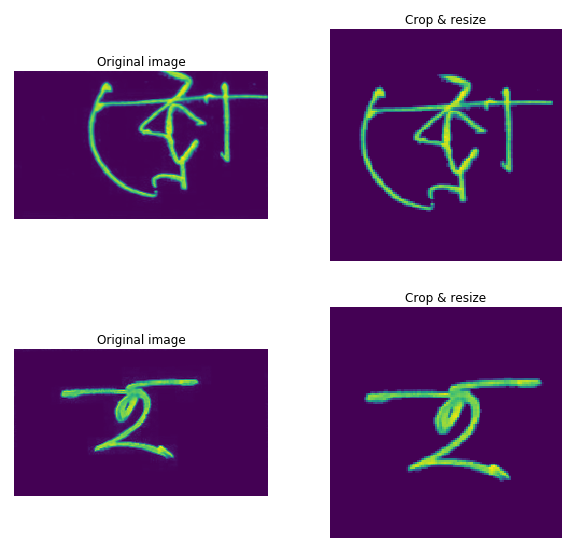

In [ ]:
# x_tot,x2_tot = [],[]
# with zipfile.ZipFile(OUT_TRAIN, 'w') as img_out:
#     for fname in TRAIN:
#         df = pd.read_parquet(fname)
#         #the input is inverted
#         data = 255 - df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH).astype(np.uint8)
#         for idx in tqdm(range(len(df))):
#             name = df.iloc[idx,0]
#             #normalize each image by its max val
#             img = (data[idx]*(255.0/data[idx].max())).astype(np.uint8)
#             img = crop_resize(img)
        
#             x_tot.append((img/255.0).mean())
#             x2_tot.append(((img/255.0)**2).mean()) 
#             img = cv2.imencode('.png',img)[1]
#             img_out.writestr(name + '.png', img)

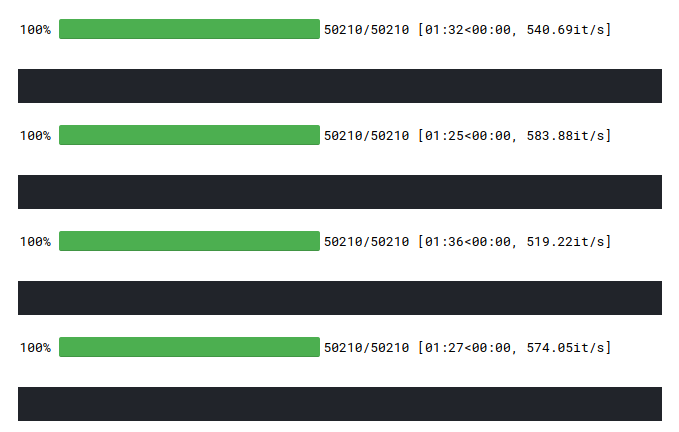

In [33]:
# TRAIN_DIR = '/home/beth/Galvanize/capstone/capstone_2_new/capstone_2/train_img'

# batch_size = 256

# datagen = ImageDataGenerator(validation_split=0.3, rescale=1./255)

# datagen = ImageDataGenerator(rescale=1./255)

# train_generator = datagen.flow_from_directory(
#     TRAIN_DIR
# )
# val_generator = datagen.flow_from_directory(
#     TRAIN_DIR
# )


Found 200840 images belonging to 1 classes.
Found 200840 images belonging to 1 classes.


In [ ]:



# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True)

# test_datagen = ImageDataGenerator(rescale=1./255)

# train_generator = train_datagen.flow_from_directory(
#         '../train_img/train',  # this is the target directory
#         target_size=(150, 150),  # all images will be resized to 150x150
#         batch_size=batch_size,
#         class_mode='binary')

# validation_generator = test_datagen.flow_from_directory(
#         '../data/validation',
#         target_size=(150, 150),
#         batch_size=batch_size,
#         class_mode='binary')

# model.fit(
#     train_generator,
#     steps_per_epoch=180 // batch_size,
#     epochs=50,
#     validation_data=validation_generator,
#     validation_steps=20 // batch_size)


In [34]:
# train_data_dir='/home/beth/Galvanize/capstone/capstone_2_new/capstone_2/train_img'

# img_height = 128
# img_width =128
# batch_size = 256

# train_datagen = ImageDataGenerator(rescale=1./255,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     validation_split=0.2) # set validation split

# train_generator = train_datagen.flow_from_directory(
#     train_data_dir,
#     target_size=(img_height, img_width),
#     batch_size=batch_size,
#     class_mode='categorical',
#     subset='training') # set as training data

# validation_generator = train_datagen.flow_from_directory(
#     train_data_dir, # same directory as training data
#     target_size=(img_height, img_width),
#     batch_size=batch_size,
#     class_mode='categorical',
#     subset='validation') # set as validation data



Found 160672 images belonging to 1 classes.
Found 40168 images belonging to 1 classes.


In [45]:
X,y=next(train_generator)

In [46]:
X.shape

(256, 128, 128, 3)

In [47]:
y.shape

(256, 1)

In [42]:
next(train_generator)[0].shape

(256, 128, 128, 3)

In [44]:
next(train_generator)[1].shape

(256, 1)

In [ ]:
plt.imshow(X[0,:,:,0])

In [98]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm.auto import tqdm
from glob import glob
import time, gc
import cv2

from tensorflow import keras
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.models import clone_model
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization, Input
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import PIL.Image as Image, PIL.ImageDraw as ImageDraw, PIL.ImageFont as ImageFont
from matplotlib import pyplot as plt
import seaborn as sns


In [ ]:
# 

In [123]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu', input_shape=(128,128,1)), 
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.BatchNormalization(momentum=0.15),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.Conv2D(filters=32, kernel_size=(5, 5), padding='SAME', activation='relu'),
    keras.layers.Dropout(rate=0.3),

    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.BatchNormalization(momentum=0.15),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.Conv2D(filters=64, kernel_size=(5, 5), padding='SAME', activation='relu'),
    keras.layers.BatchNormalization(momentum=0.15),
    keras.layers.Dropout(rate=0.3),

    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.BatchNormalization(momentum=0.15),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.Conv2D(filters=128, kernel_size=(5, 5), padding='SAME', activation='relu'),
    keras.layers.BatchNormalization(momentum=0.15),
    keras.layers.Dropout(rate=0.3),

    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.BatchNormalization(momentum=0.15),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5, 5), padding='SAME', activation='relu'),
    keras.layers.BatchNormalization(momentum=0.15),
    keras.layers.Dropout(rate=0.3),

    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation = "relu"),
    keras.layers.Dropout(rate=0.3),
    keras.layers.Dense(512, activation = "relu"),
    keras.layers.Dense(7, activation = 'softmax')   
])

opt = keras.optimizers.Adam(learning_rate=0.0001)  # <--------------------------
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', keras.metrics.Recall()])


In [124]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_160 (Conv2D)          (None, 128, 128, 32)      320       
_________________________________________________________________
conv2d_161 (Conv2D)          (None, 128, 128, 32)      9248      
_________________________________________________________________
conv2d_162 (Conv2D)          (None, 128, 128, 32)      9248      
_________________________________________________________________
conv2d_163 (Conv2D)          (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_56 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_164 (Conv2D)          (None, 64, 64, 32)       

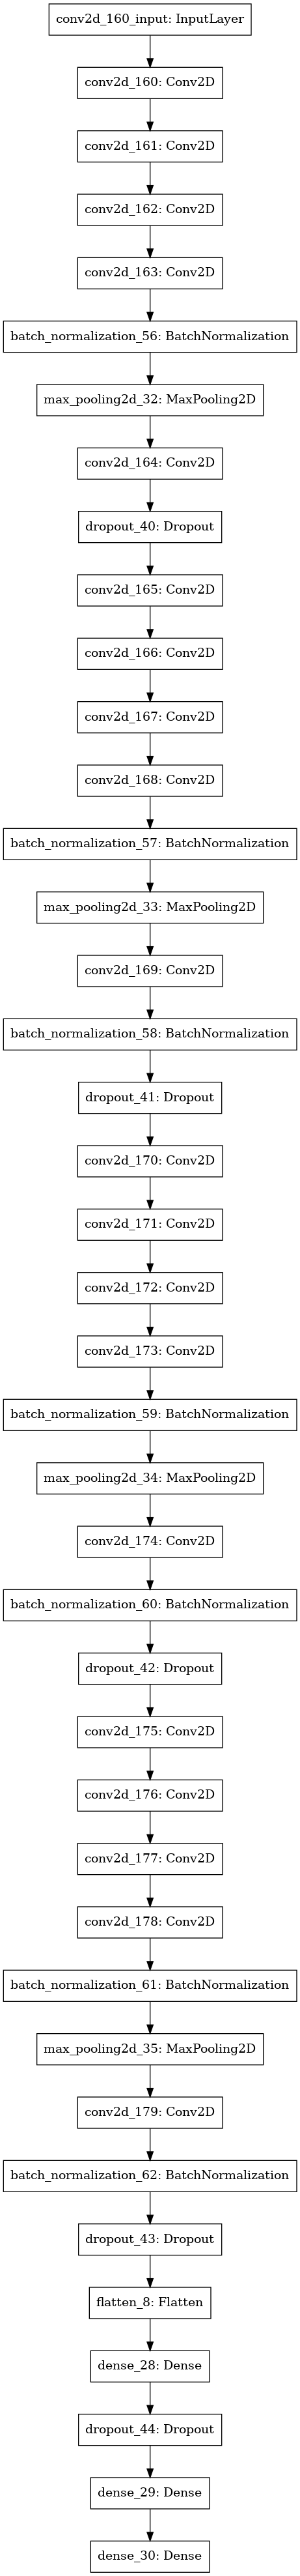

In [125]:
from keras.utils import plot_model
plot_model(model)

In [126]:
# model = Model(inputs=inputs, outputs=[head_root, head_vowel, head_consonant])


In [147]:
my_callbacks = [
    keras.callbacks.EarlyStopping(patience=100),
    keras.callbacks.TensorBoard(log_dir='./logs')]
#keras.callbacks.ModelCheckpoint(filepath='./checkpoint/model.{epoch:02d}-{val_loss:.2f}.h5')

history = model.fit(mygenerator1(train),
                    epochs=75,
                    steps_per_epoch=64, #<------------
                    validation_data=mygenerator1(test),
                    validation_steps=30, 
                    callbacks=my_callbacks)                 


Epoch 1/75
64/64 [==============================] - 13s 201ms/step - loss: 3.0933 - accuracy: 0.4219 - recall_5: 0.4219 - val_loss: 4.6643 - val_accuracy: 0.0667 - val_recall_5: 0.0667
Epoch 2/75
64/64 [==============================] - 15s 229ms/step - loss: 2.6336 - accuracy: 0.5469 - recall_5: 0.5312 - val_loss: 1.8958 - val_accuracy: 0.2333 - val_recall_5: 0.1667
Epoch 3/75
64/64 [==============================] - 14s 226ms/step - loss: 2.6416 - accuracy: 0.4219 - recall_5: 0.4062 - val_loss: 3.1523 - val_accuracy: 0.2333 - val_recall_5: 0.2333
Epoch 4/75
64/64 [==============================] - 14s 225ms/step - loss: 2.5099 - accuracy: 0.4688 - recall_5: 0.4531 - val_loss: 4.0244 - val_accuracy: 0.6667 - val_recall_5: 0.6667
Epoch 5/75
64/64 [==============================] - 15s 228ms/step - loss: 3.0701 - accuracy: 0.4844 - recall_5: 0.4375 - val_loss: 4.3997 - val_accuracy: 0.6000 - val_recall_5: 0.6000
Epoch 6/75
64/64 [==============================] - 14s 222ms/step - loss: 

In [148]:
score = model.evaluate(mygenerator1(test), steps=200,verbose=0)

print('Test score:', score[0])
print('Test accuracy:', score[1])  # this is the one we care about

Test score: 2.7546441555023193
Test accuracy: 0.6499999761581421


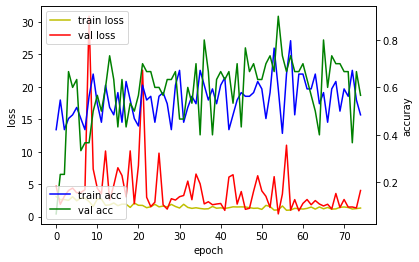

In [149]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()


In [182]:
# [plt.plot(history.history[i], label=i) for i in history.history.keys()]
# plt.legend();

In [151]:
# confusion matrix
# from sklearn.metrics import confusion_matrix

# y_pred = model.predict(mygenerator(test),steps=200) # probability
# y_pred = np.argmax(y_pred, axis=1) # index of highest prob 
# y_pred

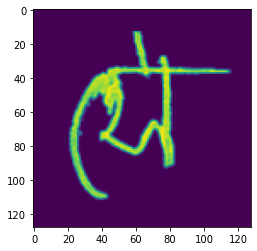

In [153]:
x,y= next(mygenerator1(test))
x.shape
y.shape
plt.imshow(x[0,:,:,0])

In [155]:
prediction = [] 
actual = []
for x,y in mygenerator1(test):
#     plt.imshow(x[0,:,:,0])
    actual.append(y.argmax())
    prediction.append(model.predict(x).argmax())
    if len(actual)>200:
        break     

In [35]:
# actual

In [36]:
# prediction

In [156]:
# confusion matrix
from sklearn.metrics import confusion_matrix
print('Confusion Matrix')
multiclass=confusion_matrix(actual, prediction)
print(multiclass)

Confusion Matrix
[[119   0   4   0   2   0]
 [ 11   0   0   0   0   0]
 [ 11   0  11   0   0   0]
 [ 18   0   0   0   1   0]
 [ 20   0   1   0   1   0]
 [  2   0   0   0   0   0]]


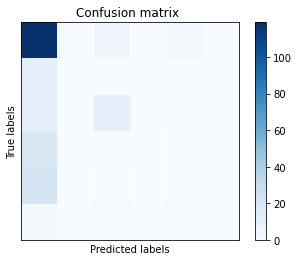

In [158]:
cm = confusion_matrix(actual, prediction)

plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()


# vowel_diacritic

In [160]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu', input_shape=(128,128,1)), 
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.BatchNormalization(momentum=0.15),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.Conv2D(filters=32, kernel_size=(5, 5), padding='SAME', activation='relu'),
    keras.layers.Dropout(rate=0.3),

    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.BatchNormalization(momentum=0.15),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.Conv2D(filters=64, kernel_size=(5, 5), padding='SAME', activation='relu'),
    keras.layers.BatchNormalization(momentum=0.15),
    keras.layers.Dropout(rate=0.3),

    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.BatchNormalization(momentum=0.15),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.Conv2D(filters=128, kernel_size=(5, 5), padding='SAME', activation='relu'),
    keras.layers.BatchNormalization(momentum=0.15),
    keras.layers.Dropout(rate=0.3),

    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.BatchNormalization(momentum=0.15),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5, 5), padding='SAME', activation='relu'),
    keras.layers.BatchNormalization(momentum=0.15),
    keras.layers.Dropout(rate=0.3),

    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation = "relu"),
    keras.layers.Dropout(rate=0.3),
    keras.layers.Dense(512, activation = "relu"),
    keras.layers.Dense(11, activation = 'softmax')   
])

opt = keras.optimizers.Adam(learning_rate=0.0001)  # <--------------------------
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', keras.metrics.Recall()])


In [161]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_180 (Conv2D)          (None, 128, 128, 32)      320       
_________________________________________________________________
conv2d_181 (Conv2D)          (None, 128, 128, 32)      9248      
_________________________________________________________________
conv2d_182 (Conv2D)          (None, 128, 128, 32)      9248      
_________________________________________________________________
conv2d_183 (Conv2D)          (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_63 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_184 (Conv2D)          (None, 64, 64, 32)       

In [162]:
my_callbacks = [
    keras.callbacks.EarlyStopping(patience=100),
    keras.callbacks.TensorBoard(log_dir='./logs')]
#keras.callbacks.ModelCheckpoint(filepath='./checkpoint/model.{epoch:02d}-{val_loss:.2f}.h5')

history = model.fit(mygenerator2(train),
                    epochs=30,
                    steps_per_epoch=180, #<------------
                    validation_data=mygenerator2(test),
                    validation_steps=30, 
                    batch_size=256,
                    callbacks=my_callbacks)                 


Epoch 1/30
180/180 [==============================] - 37s 200ms/step - loss: 3.9585 - accuracy: 0.1180 - recall_6: 0.0891 - val_loss: 2.9882 - val_accuracy: 0.2000 - val_recall_6: 0.0333
Epoch 2/30
180/180 [==============================] - 39s 218ms/step - loss: 3.9107 - accuracy: 0.1770 - recall_6: 0.1635 - val_loss: 3.0475 - val_accuracy: 0.1333 - val_recall_6: 0.1000
Epoch 3/30
180/180 [==============================] - 38s 211ms/step - loss: 3.2213 - accuracy: 0.1801 - recall_6: 0.1015 - val_loss: 4.1265 - val_accuracy: 0.3333 - val_recall_6: 0.3000
Epoch 4/30
180/180 [==============================] - 39s 216ms/step - loss: 2.8119 - accuracy: 0.2709 - recall_6: 0.1819 - val_loss: 11.1498 - val_accuracy: 0.1667 - val_recall_6: 0.1333
Epoch 5/30
180/180 [==============================] - 39s 217ms/step - loss: 2.8131 - accuracy: 0.1071 - recall_6: 0.0236 - val_loss: 5.9397 - val_accuracy: 0.2000 - val_recall_6: 0.1333
Epoch 6/30
180/180 [==============================] - 39s 218ms/

In [163]:
score = model.evaluate(mygenerator2(test), steps=1000,verbose=0)

print('Test score:', score[0])
print('Test accuracy:', score[1])  # this is the one we care about

Test score: 1.8599588871002197
Test accuracy: 0.5040000081062317


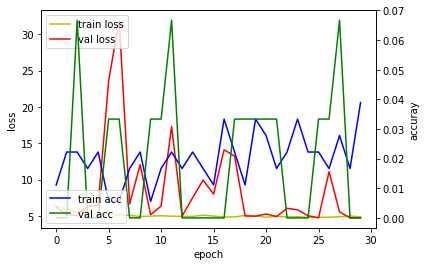

In [179]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()


In [183]:
# [plt.plot(history.history[i], label=i) for i in history.history.keys()]
# plt.legend();

In [181]:
prediction = [] 
actual = []
for x,y in mygenerator2(test):
#     plt.imshow(x[0,:,:,0])
    actual.append(y.argmax())
    prediction.append(model.predict(x).argmax())
    if len(actual)>200:
        break     

In [184]:
# confusion matrix
from sklearn.metrics import confusion_matrix
print('Confusion Matrix')
cm=confusion_matrix(actual, prediction)
print(cm)

Confusion Matrix
[[ 0  0  0  0  0  0  0  0  0  0  0  0  1  0  2 10 14 19  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  0  3  0  4 26  0  3]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  2  1  2  4 11  7  0  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  0  4  0  2 11  0  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  9  1  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  6  4  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  2  1  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  0  0  1  7  6  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  3 10  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 

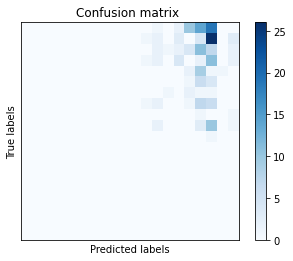

In [185]:
cm = confusion_matrix(actual, prediction)

plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()


# grapheme_root

In [170]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu', input_shape=(128,128,1)), 
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.BatchNormalization(momentum=0.15),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.Conv2D(filters=32, kernel_size=(5, 5), padding='SAME', activation='relu'),
    keras.layers.Dropout(rate=0.3),

    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.BatchNormalization(momentum=0.15),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.Conv2D(filters=64, kernel_size=(5, 5), padding='SAME', activation='relu'),
    keras.layers.BatchNormalization(momentum=0.15),
    keras.layers.Dropout(rate=0.3),

    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.BatchNormalization(momentum=0.15),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.Conv2D(filters=128, kernel_size=(5, 5), padding='SAME', activation='relu'),
    keras.layers.BatchNormalization(momentum=0.15),
    keras.layers.Dropout(rate=0.3),

    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.BatchNormalization(momentum=0.15),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5, 5), padding='SAME', activation='relu'),
    keras.layers.BatchNormalization(momentum=0.15),
    keras.layers.Dropout(rate=0.3),

    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation = "relu"),
    keras.layers.Dropout(rate=0.3),
    keras.layers.Dense(512, activation = "relu"),
    keras.layers.Dense(168, activation = 'softmax')   
])

opt = keras.optimizers.Adam(learning_rate=0.0001)  # <--------------------------
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', keras.metrics.Recall()])


In [171]:
my_callbacks_3 = [keras.callbacks.EarlyStopping(patience=100),
                  keras.callbacks.TensorBoard(log_dir='./logs_3')]
#keras.callbacks.ModelCheckpoint(filepath='./checkpoint/model.{epoch:02d}-{val_loss:.2f}.h5')

history = model.fit(mygenerator3(train),
                    epochs=30,
                    steps_per_epoch=180, #<------------
                    validation_data=mygenerator3(test),
                    validation_steps=30, 
                    callbacks=my_callbacks_3)                 


Epoch 1/30
180/180 [==============================] - 39s 208ms/step - loss: 6.2146 - accuracy: 0.0131 - recall_8: 0.0118 - val_loss: 6.2404 - val_accuracy: 0.0000e+00 - val_recall_8: 0.0000e+00
Epoch 2/30
180/180 [==============================] - 40s 220ms/step - loss: 5.8742 - accuracy: 0.0209 - recall_8: 0.0000e+00 - val_loss: 5.1580 - val_accuracy: 0.0000e+00 - val_recall_8: 0.0000e+00
Epoch 3/30
180/180 [==============================] - 39s 214ms/step - loss: 5.5533 - accuracy: 0.0477 - recall_8: 0.0000e+00 - val_loss: 5.0833 - val_accuracy: 0.0667 - val_recall_8: 0.0000e+00
Epoch 4/30
180/180 [==============================] - 38s 214ms/step - loss: 5.4640 - accuracy: 0.0082 - recall_8: 0.0000e+00 - val_loss: 6.3223 - val_accuracy: 0.0000e+00 - val_recall_8: 0.0000e+00
Epoch 5/30
180/180 [==============================] - 38s 214ms/step - loss: 5.2926 - accuracy: 0.0208 - recall_8: 0.0000e+00 - val_loss: 6.4850 - val_accuracy: 0.0000e+00 - val_recall_8: 0.0000e+00
Epoch 6/30
18

In [172]:
score = model.evaluate(mygenerator3(test), steps=200,verbose=0)

print('Test score:', score[0])
print('Test accuracy:', score[1])  # this is the one we care about

Test score: 4.7975382804870605
Test accuracy: 0.02500000037252903


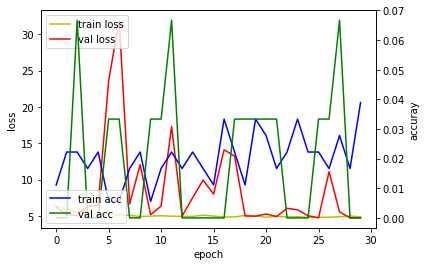

In [178]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()


In [187]:
# [plt.plot(history.history[i], label=i) for i in history.history.keys()]
# plt.legend();

In [175]:
prediction = [] 
actual = []
for x,y in mygenerator3(test):
#     plt.imshow(x[0,:,:,0])
    actual.append(y.argmax())
    prediction.append(model.predict(x).argmax())
    if len(actual)>1000:
        break     

In [190]:
len(actual)

201

In [191]:
len(prediction)

201

In [176]:
# confusion matrix
from sklearn.metrics import confusion_matrix
print('Confusion Matrix')
cm=confusion_matrix(actual, prediction)
print(cm)

Confusion Matrix
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


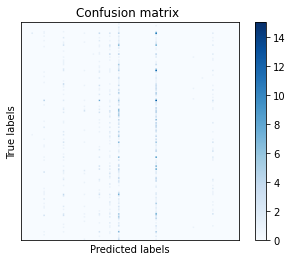

In [177]:
multiclass = confusion_matrix(actual, prediction)

plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()


# NOT GOOD


consonant_diacritic

- Test score: 2.7546441555023193
- Test accuracy: 0.6499999761581421


vowel_diacritic

- Test score: 1.8599588871002197
- Test accuracy: 0.5040000081062317


grapheme_root

- Test score: 4.7975382804870605
- Test accuracy: 0.02500000037252903
